### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.utils.tensorboard import SummaryWriter
from scripts.data.dataset import DSLRDataset
from scripts.data.transforms import ToTensor, Normalize
from scripts.utils.load_save_models import save_checkpoint, get_latest_checkpoint, inference, load_checkpoint
from scripts.utils.visualizer import visualize_predictions, visualize_dataloader

# Set CUDA_LAUNCH_BLOCKING for accurate stack trace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()

# Set PYTORCH_CUDA_ALLOC_CONF to manage memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'



/home/hua/anaconda3/envs/scannetpp/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/hua/anaconda3/envs/scannetpp/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Prepare for Dataset

In [2]:
# Paths to dataset and split files
data_dir = 'dataset/2d_data'
train_split_file = 'dataset/splits/nvs_sem_train.txt'
val_split_file = 'dataset/splits/nvs_sem_val.txt'

# Define the transforms
transform = T.Compose([
    ToTensor(),
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Dataset

In [3]:
########################TODO：这里可能需要修改dataset的逻辑########################
# Create datasets and dataloaders
train_dataset = DSLRDataset(data_dir, train_split_file, transform=transform)
val_dataset = DSLRDataset(data_dir, val_split_file, transform=transform)


# 这里dataset的逻辑是1个batch对应1个scene
# 1个batch中包含了多个图片， 每次随即选取一个图片作为batch的sample
# 但是我门需要的是1个batch中包含多个图片，所以需要修改dataset的逻辑
################################################################################


# Get length of datasets
train_len = len(train_dataset)
val_len = len(val_dataset)
print('Train dataset length:', train_len)
print('Val dataset length:', val_len)


# check a random sample's shape:
idx = torch.randint(0, train_len, (1,)).item()
sample = train_dataset[idx]
print(f'Random sample shape: {idx}', sample['depth'].shape)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)


# check if the dataloader's shapes are correct, including the batch size
print('Train dataloader shape:', next(iter(train_loader))['image'].shape)
print('Val dataloader shape:', next(iter(val_loader))['image'].shape)




Train dataset length: 1
Val dataset length: 1
Random sample shape: 0 torch.Size([448, 672])
Train dataloader shape: torch.Size([1, 3, 448, 672])
Val dataloader shape: torch.Size([1, 3, 448, 672])


### Visualize first

Visualizing 2d_data from the dataloader...
Loaded palette: [[0.40784314 0.8        1.        ]
 [0.7372549  0.74117647 0.13333333]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.83921569 0.15294118 0.15686275]]
Input image shape: (448, 672, 3), min: 0.0, max: 1.0
Label image shape: (448, 672), unique values: [-100   -1    0    2    3    6    9   13   15   18   21   61]


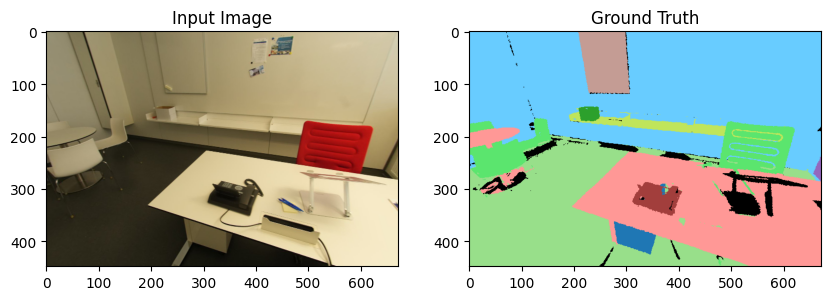

In [4]:
# Visualize 2d_data from the dataloader before training
print("Visualizing 2d_data from the dataloader...")
visualize_dataloader(val_loader, palette_file='scripts/utils/palette_scannet200.txt', num_samples=2)

### Training preparation

In [5]:
from scripts.networks.nn_2d_segformer import Segformer_Segmentation
from scripts.networks.nn_spconv import SimpleSpConvNet

# Clear GPU cache
torch.cuda.empty_cache()
# Instantiate the model and move it to the device: SegFormer

model = Segformer_Segmentation(num_classes=101) #注意cuda out of memory, 需要修改scripts/networks/nn_2d_segformer.py里面的结构


model3d = SimpleSpConvNet(num_classes=101)

# model to device
model = model.to(device)
model3d = model3d.to(device)

# Define the ignore index for invalid labels
IGNORE_INDEX = -1

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 

# Check the model architecture
print(model)
# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='./runs')


/home/hua/anaconda3/envs/scannetpp/lib/python3.10/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hua/anaconda3/envs/scannetpp/lib/python3.10/site-packages/transformers/utils/generic.py:339: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Segformer_Segmentation(
  (backbone): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
   

### Load the latest

In [7]:
from scripts.utils.load_save_models import get_latest_checkpoint
# Create the checkpoints directory
checkpoint_dir = './checkpoints'

### 注意，这里必须要有一个checkpoint的文件夹，否则会报错
# 另外，每次都是自动从最新的checkpoint开始训练的

# Load latest checkpoint if available
# latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
latest_checkpoint = False
start_epoch = 0
if latest_checkpoint:
    start_epoch, _ = load_checkpoint(latest_checkpoint, model, optimizer)
    print(f"Resuming training from epoch {start_epoch}")


### Train loop

In [8]:
import torch
import torch.nn.functional as F
from scripts.networks.utils_projection import project_to_3d
# from scripts.networks.utils_projection import apply_softmax, colorize_point_cloud, save_point_cloud_to_ply,load_palette
from scripts.networks.utils_voxelization import PC2Tensor


# 定义计算准确率的函数
def calculate_accuracy(outputs, labels, ignore_index):
    # 获取预测的标签
    preds = torch.argmax(outputs, dim=1)
    valid_mask = labels != ignore_index
    correct = torch.sum(preds[valid_mask] == labels[valid_mask]).item()
    total = torch.sum(valid_mask).item()
    return correct / total if total > 0 else 0

# Training loop
num_epochs = 2000
save_interval = 10  # Save a checkpoint every 10 epochs

for epoch in range(start_epoch, num_epochs):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    for i, images in enumerate(train_loader):
        inputs = images['image'].to(device)
        labels = images['label'].to(device)
        ##############################################
        #这里可以加入相机的内参外参
        depth = images['depth'].to(device)
        R = images['R'].to(device)
        T = images['T'].to(device)
        K = images['intrinsic_mat'].to(device)
        
        # Identify invalid labels and set them to IGNORE_INDEX
        invalid_mask = (labels < 0)
        labels[invalid_mask] = IGNORE_INDEX
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        ##########################################################################################################
        # 特征点云的生成
        point_cloud_features = project_to_3d(outputs, depth, K, R, T, ignore_index=IGNORE_INDEX)
        # # 这个就是我们需要得到的点云特征的数据了，形状为(B, N, 3 + C_classes)
        # save_path = f'./point_cloud_features_epoch.pth'
        # torch.save(point_cloud_features, save_path)
        
        #################################################
        ################TODO：3D网络从这里接入##############
        '''
        接下来可能有这些步骤：
        '''
        # Step 0: 2D部分最后的任务：
        # a) 尽量不修改2d网络结构，通过修改dataset，或者别的方式，使得模型可以推理两张不同的图片（同一个场景）
        # b) 模型推理两张图片，得到上述的两份特征点云，并且将两张图片的特征点云数据拼接在一起
        
        # Step 1: 定义新的dataloader用于3d训练数据，将用来提取scannetpp的点云数据作为几何信息
        
        # Step 2: 定义一个Voxelizer，用来处理任何形状为(B, N, 3)的点云数据
        
        # Step 3: 定义一个3D网络，用来处理这两部分体素化数据
        
        # 尝试接入3D网络
        
        spatial_shape = [30, 40, 40]
        pc2tensor = PC2Tensor(device, spatial_shape)
        spconv_tensor = pc2tensor(point_cloud_features)
        output3d = model3d(spconv_tensor)
        
        print('3D Output shape:', output3d, '\n')
        
        
        
        
        
        
        # # 这里是用来检测点云是否生成正确，正式运行的时候可以注释掉
        # # Apply softmax and convert to integer predictions
        # point_cloud_with_predictions = apply_softmax(point_cloud_features)
        # palette = load_palette('scripts/utils/palette_scannet200.txt')
        # # Colorize point cloud using the predictions and palette
        # point_cloud_with_colors = colorize_point_cloud(point_cloud_with_predictions, palette)

        # # Save the colored point cloud to PLY files
        # save_point_cloud_to_ply(point_cloud_with_colors, './outputs')
        ###################END OF TODO##############################################################################
        ############################################################################################################
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # 计算准确率
        corrects = calculate_accuracy(outputs, labels, IGNORE_INDEX)
        running_corrects += corrects * inputs.size(0)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {epoch_acc}")

    # Log training loss and accuracy to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)
    writer.add_scalar('Training Accuracy', epoch_acc, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0
    with torch.no_grad():
        for i, images in enumerate(val_loader):
            inputs = images['image'].to(device)
            labels = images['label'].to(device)
            ####################################################
            ############TODO: 根据train同理修改这一部分############ 
            
            invalid_mask = (labels < 0)
            labels[invalid_mask] = IGNORE_INDEX
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            
            ###############END OF TODO##########################
            ####################################################
            # 计算准确率
            corrects = calculate_accuracy(outputs, labels, IGNORE_INDEX)
            val_corrects += corrects * inputs.size(0)
            val_samples += inputs.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = val_corrects / val_samples
    print(f"Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_acc}")

    # Log validation loss and accuracy to TensorBoard
    writer.add_scalar('Validation Loss', epoch_val_loss, epoch)
    writer.add_scalar('Validation Accuracy', epoch_val_acc, epoch)

    # Save a checkpoint
    if (epoch + 1) % save_interval == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_dir, filename=f'checkpoint_epoch_{epoch+1}.pth.tar')

print("Training complete")
writer.close()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
3D Output shape: SparseConvTensor[shape=torch.Size([2152, 32])] 

Epoch [1/2000], Loss: 4.649531841278076, Accuracy: 0.004365290002614421
Validation Loss: 4.40088415145874, Validation Accuracy: 0.3982376879569596
3D Output shape: SparseConvTensor[shape=torch.Size([2152, 32])] 

Epoch [2/2000], Loss: 4.4193315505981445, Accuracy: 0.4161325590423298
Validation Loss: 3.879438638687134, Validation Accuracy: 0.42843123125596205
3D Output shape: SparseConvTensor[shape=torch.Size([2152, 32])] 

Epoch [3/2000], Loss: 3.856804132461548, Accuracy: 0.4161325590423298
Validation Loss: 2.954885244369507, Validation Accuracy: 0.3982376879569596
3D Output shape: SparseConvTensor[shape=torch.Size([2081, 32])] 

Epoch [4/2000], Loss: 3.9252829551696777, Accuracy: 0.42843123125596205
Validation Loss: 2.884923219680786, Validation Accurac

Exception ignored in: <function _releaseLock at 0x7fe12e124700>
Traceback (most recent call last):
  File "/home/hua/anaconda3/envs/scannetpp/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Validation Loss: 2.132035255432129, Validation Accuracy: 0.23534934203750504
3D Output shape: SparseConvTensor[shape=torch.Size([2152, 32])] 

Epoch [28/2000], Loss: 2.1325571537017822, Accuracy: 0.23012446226123606
Validation Loss: 2.1167972087860107, Validation Accuracy: 0.5034423203378148
3D Output shape: SparseConvTensor[shape=torch.Size([2152, 32])] 

Epoch [29/2000], Loss: 2.110147714614868, Accuracy: 0.5054387869088834
Validation Loss: 2.0822527408599854, Validation Accuracy: 0.46449141598599303
3D Output shape: SparseConvTensor[shape=torch.Size([1407, 32])] 

Epoch [30/2000], Loss: 1.459418773651123, Accuracy: 0.4508242516209132
Validation Loss: 1.815678358078003, Validation Accuracy: 0.4608923019908999
3D Output shape: SparseConvTensor[shape=torch.Size([2081, 32])] 

Epoch [31/2000], Loss: 1.7759872674942017, Accuracy: 0.4756267457261878
Validation Loss: 1.7693653106689453, Validation Accuracy: 0.4642550767604812
3D Output shape: SparseConvTensor[shape=torch.Size([2081, 32])] 

### Inference and visualizations

In [ ]:
# Inference and visualize predictions
inference_checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_830.pth.tar')
inputs, labels, predictions = inference(model, val_loader, device, num_samples=2)
# Get the tensor inside the prediction
print('Predictions shape:', predictions[0].shape)
print('Predictions:', predictions)

## 注意这里的visualize_predictions和visualize_dataloader，前者是用来展示预测结果的，后者是用来展示dataloader的
## 但是不得不说写的很栏，只是勉强跑通了
visualize_predictions(inputs, labels, predictions, palette_file='scripts/utils/palette_scannet200.txt')